In [35]:
import pandas as pd 
import numpy as np
import os
import faiss
import cv2
import matplotlib.pyplot as plt

from skimage.feature import graycomatrix, graycoprops
import warnings
warnings.simplefilter("ignore")

### HISTOGRAMAS DE TEXTURA FEATURE SELECTOR

In [36]:
paths_db = pd.read_csv("database\db.csv", index_col=0)
paths = paths_db["path"].values.tolist()

In [37]:
# I want to get the features for different distances and angles
distances = [1, 3, 5, 7]
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

def get_glcm_features(image_path, distances, angles):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Calcular la GLCM
    glcm = graycomatrix(img, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)
   
    # Extraer características: contraste, correlación, energía y homogeneidad
    contrast = graycoprops(glcm, 'contrast').flatten()
    correlation = graycoprops(glcm, 'correlation').flatten()
    energy = graycoprops(glcm, 'energy').flatten()
    homogeneity = graycoprops(glcm, 'homogeneity').flatten()
    #I want more features
    #ASM
    asm = graycoprops(glcm, 'ASM').flatten()
    #Dissimilarity
    dissimilarity = graycoprops(glcm, 'dissimilarity').flatten()
   
    # Combinar todas las características en un solo vector
    features = np.hstack([contrast, correlation, energy, homogeneity, asm, dissimilarity])
    return features

In [38]:
all_features = []
dimension = 256
for path in paths:
    features = get_glcm_features(path, distances=distances, angles=angles)
    all_features.append(features)

all_features[2]

array([7.51221351e+02, 9.82038562e+02, 6.08039181e+02, 9.94473149e+02,
       1.32309963e+03, 1.35259909e+03, 1.47470446e+03, 1.54204048e+03,
       1.64352493e+03, 1.94724012e+03, 1.95084378e+03, 2.16166179e+03,
       1.85313675e+03, 2.17287824e+03, 2.34802659e+03, 2.36420135e+03,
       9.01536099e-01, 8.71056792e-01, 9.20234582e-01, 8.69424582e-01,
       8.26178973e-01, 8.21860462e-01, 8.05887581e-01, 7.96926016e-01,
       7.83641169e-01, 7.42091211e-01, 7.42475927e-01, 7.13801002e-01,
       7.55583350e-01, 7.11517723e-01, 6.89468427e-01, 6.86312694e-01,
       3.34106833e-02, 2.73031692e-02, 2.90986133e-02, 2.67798433e-02,
       2.61492558e-02, 2.26043183e-02, 2.15668322e-02, 2.24909281e-02,
       2.34637653e-02, 1.80711549e-02, 1.80416837e-02, 1.84308495e-02,
       2.11695346e-02, 1.65348331e-02, 1.49482436e-02, 1.70355638e-02,
       2.59675420e-01, 1.71166471e-01, 1.92159322e-01, 1.66981709e-01,
       1.76562400e-01, 1.35458081e-01, 1.22271093e-01, 1.29761277e-01,
      

In [39]:
vectores = np.array(all_features).astype(np.float32)
dimension = vectores[0].shape[0]


index = faiss.IndexFlatL2(dimension)

faiss.normalize_L2(vectores)

index.add(vectores)

# Guardar el índice en la carpeta database
faiss.write_index(index, "database\histograms_texture.index")

In [44]:
#Buscar 5 imagenes  similares
def buscar_imagenes_similares(image_path, index, k=5):
    features = get_glcm_features(image_path, distances=distances, angles=angles)
    features = np.array([features]).astype(np.float32)
    faiss.normalize_L2(features)
    D, I = index.search(features, k)
    return I.flatten()

image_path = paths[70]
similar_images = buscar_imagenes_similares(image_path, index)
similar_images

array([ 70, 151, 115,   6, 435], dtype=int64)

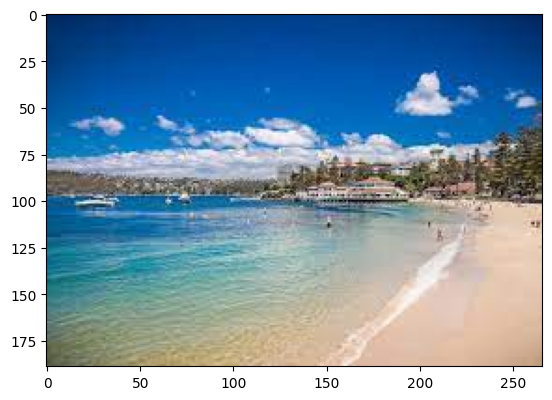

In [45]:
img_test = cv2.imread(image_path)
img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
plt.imshow( img_test)


archive\Training Data\Coast\Coast-Train (1061).jpeg


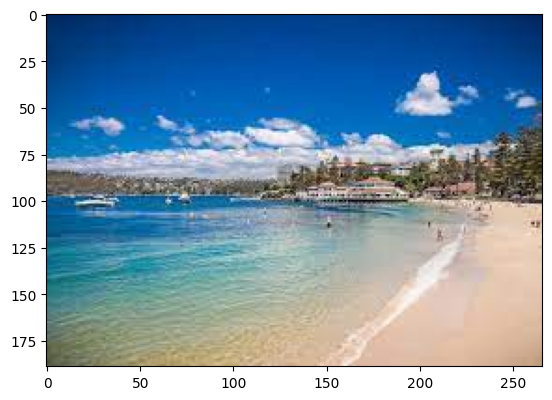

archive\Training Data\Desert\Desert-Train (1044).jpeg


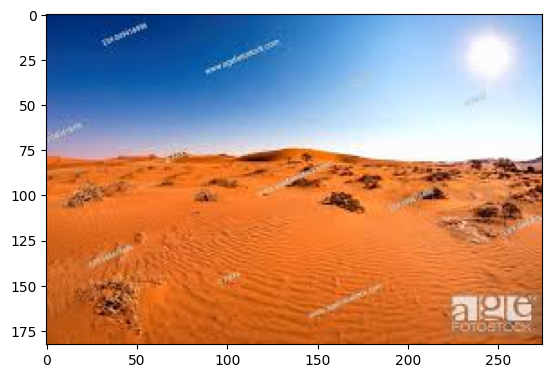

archive\Training Data\Desert\Desert-Train (1011).jpeg


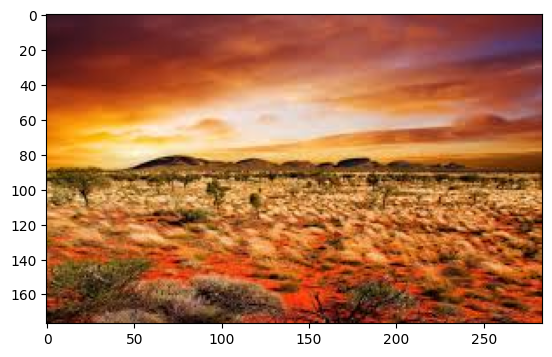

archive\Training Data\Coast\Coast-Train (1003).jpeg


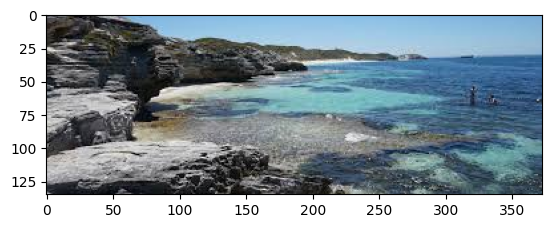

archive\Training Data\Mountain\Mountain (3006).jpeg


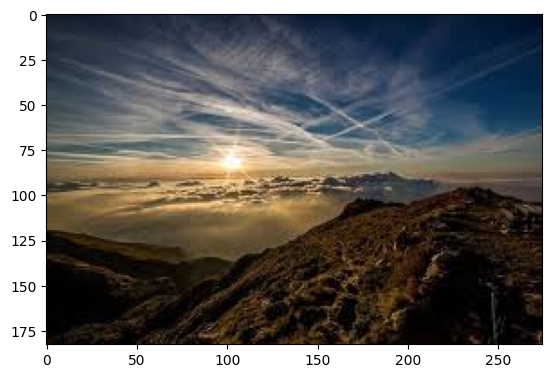

In [46]:
#con los indices saca el path y muestra las imagenes
for i in similar_images:
    print(paths[i])
    img = cv2.imread(paths[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()